## AutoGIS Part 2

This series of lessons is about automating Geographic Information Systems (GIS) processes.  It draws directly from the excellent AutoGIS course developed by the University of Helsinki:

https://automating-gis-processes.github.io/site/index.html

## Group Project

We introduce a group project that the class is to complete together over the next week.  The goal of the project is to calculate the number of lane miles of roadway in each urbanized area in Kentucky.  We will do this in three steps:

1. In class today, we will work through the AutoGIS lessons you will need to do this, and point you to other lessons that may be useful.

2. For Thursday, your group is to propose the basic method for how you will approach this.  You should write this down in english or in psuedo code, but you are not to write any python code.  You should identify specific files you will work with and specific data fields you will reference.  Each group will present their approach in class on Thursday.  

3. For next Tuesday, your group will work together to implement your strategy.  In class on Tuesday, we will compare the answers to see if the groups get the same result.  

The data you need are avialable from the Kentucky Transportation Cabinet here: 

https://transportation.ky.gov/Planning/Pages/Centerlines.aspx

## Lessons

Several relevant lessons are available from the AutoGIS course:

L2/01-geopandas-basics.ipynb

L2/02-projections.ipynb

L3/02_point-in-polygon.ipynb

L3/03_spatial-join.ipynb

L3/04_nearest-neighbhor.ipynb
(see options for making it faster if needed)

L4/geometric-operations.ipynb

In [4]:
import geopandas as gpd
#read through lane shape file into Geo Data Frame
t_lanes = gpd.read_file('KYTC/LN/LN.shp')
t_lanes.head()

,RT_UNIQUE,BEGIN_MP,END_MP,D_BEGIN_MP,D_END_MP,MILES,GOV_LEVEL,D_GOV_LEVE,RT_DESCR,DISTRICT,...,D_RT_SECTI,START_DATE,MODIFY_DT,EXTRACT_DT,LANEWID,LANES,LANESCRD,LANESNC,GEOLOC_STL,geometry
0,030-AU-9005 -000,15.883,23.441,015.883,023.441,7.558,01,State Maintained Roads,AUDUBON PKWY,2.0,...,Mainline,2000-09-14,2005-09-14,2021-02-27,12.0,4.0,2.0,2.0,40127.094256,"LINESTRING (4474076.800 3802666.900, 4474373.0..."
1,051-AU-9005 -000,0.000,15.883,000.000,015.883,15.883,01,State Maintained Roads,AUDUBON PKWY,2.0,...,Mainline,2007-09-10,2007-09-11,2021-02-27,12.0,4.0,2.0,2.0,83795.045967,"LINESTRING (4397334.400 3823505.400, 4397433.1..."
2,051-AU-9005 -211,0.000,0.402,000.000,000.402,0.402,01,State Maintained Roads,AUDUBON PKWY RAMP to KY 1078,2.0,...,Ramp,2016-10-24,2016-10-24,2021-02-27,16.0,1.0,1.0,0.0,2120.274422,"LINESTRING (4422316.600 3815013.200, 4422377.5..."
3,051-AU-9005 -221,0.000,0.356,000.000,000.356,0.356,01,State Maintained Roads,AUDUBON PKWY RAMP from KY 1078,2.0,...,Ramp,2016-10-24,2016-10-24,2021-02-27,16.0,1.0,1.0,0.0,1877.678617,"LINESTRING (4424034.000 3813423.700, 4424035.9..."
4,051-AU-9005 -231,0.000,0.379,000.000,000.379,0.379,01,State Maintained Roads,AUDUBON PKWY RAMP to KY 1078,2.0,...,Ramp,2016-10-24,2016-10-24,2021-02-27,16.0,1.0,1.0,0.0,2001.247725,"LINESTRING (4425272.900 3813781.900, 4425220.2..."


In [5]:
#read urbanize areas shape file into Geo Data Frame
urb_areas = gpd.read_file('KYTC/Ubanized Areas/FHWA_Urbanized_Areas_2010.shp')
urb_areas.head()

,Name,Area_Type,Latitude,Longitude,Part_KY,Population,PopDensity,Area_SqMi,geometry
0,"Barbourville, KY",Small Urb,+36.8607419,-083.8547626,None,6300.0,1246.4,6.263393,"MULTIPOLYGON (((5496792.179 3472180.088, 54968..."
1,"Beaver Dam, KY",Small Urb,+37.3984456,-086.8740011,None,6321.0,1512.2,4.917061,"MULTIPOLYGON (((4589837.470 3685787.053, 45904..."
2,"Berea, KY",Small Urb,+37.5835618,-084.2930193,None,15590.0,1181.4,17.986753,"MULTIPOLYGON (((5330968.090 3723250.426, 53309..."
3,"Bowling Green, KY",Urbanized,+36.9556909,-086.4391654,None,78306.0,1724.7,57.662179,"MULTIPOLYGON (((4700251.900 3525305.102, 47002..."
4,"Campbellsville, KY",Small Urb,+37.3525543,-085.3464954,None,11719.0,1513.4,9.846162,"POLYGON ((5042714.061 3659975.479, 5042727.658..."


In [6]:
#checking through-lane-file's CRS
t_lanes.crs

<Projected CRS: EPSG:3089>
Name: NAD83 / Kentucky Single Zone (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Kentucky.
- bounds: (-89.57, 36.49, -81.95, 39.15)
Coordinate Operation:
- name: SPCS83 Kentucky Single Zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
#checking urbanized area file's CRS
urb_areas.crs

<Projected CRS: EPSG:3089>
Name: NAD83 / Kentucky Single Zone (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Kentucky.
- bounds: (-89.57, 36.49, -81.95, 39.15)
Coordinate Operation:
- name: SPCS83 Kentucky Single Zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
# Ensure that the CRS matches, if not raise an AssertionError
assert t_lanes.crs == urb_areas.crs, "CRS differs between layers!"

In [9]:
#creating a new geodataframe that's only the lanes in Urbanized Areas
urb_lanes = gpd.overlay(t_lanes, urb_areas, how='intersection')
urb_lanes.head()

,RT_UNIQUE,BEGIN_MP,END_MP,D_BEGIN_MP,D_END_MP,MILES,GOV_LEVEL,D_GOV_LEVE,RT_DESCR,DISTRICT,...,GEOLOC_STL,Name,Area_Type,Latitude,Longitude,Part_KY,Population,PopDensity,Area_SqMi,geometry
0,030-AU-9005 -000,15.883,23.441,015.883,023.441,7.558,01,State Maintained Roads,AUDUBON PKWY,2.0,...,40127.094256,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"MULTILINESTRING ((4491551.901 3804308.889, 449..."
1,030-CR-1013 -000,0.000,0.425,000.000,000.425,0.425,02,County Maintained Roads,PLEASANT VALLEY RD - 1,2.0,...,2243.655342,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4538135.900 3811551.600, 4538165.6..."
2,030-CR-1079 -000,0.000,0.441,000.000,000.441,0.441,02,County Maintained Roads,WRIGHTS LANDING RD,2.0,...,2375.564007,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4551526.500 3826430.900, 4551442.5..."
3,030-CR-1081 -000,0.000,1.228,000.000,001.228,1.228,02,County Maintained Roads,GRAHAM LN,2.0,...,6525.178602,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4550755.500 3811369.200, 4550771.9..."
4,030-CR-1089 -000,0.000,1.375,000.000,001.375,1.375,02,County Maintained Roads,HAYDEN RD,2.0,...,7259.687753,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4550779.845 3806848.530, 4550232.3..."


<AxesSubplot:>

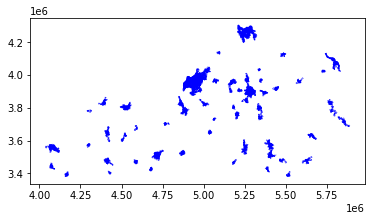

In [10]:
#checking to see if that operation worked as I thought
urb_lanes.plot(color="b")

In [11]:
#outputting shape file to see if lanes cut exactly at urbanized boundries
urb_lanes.to_file("urban_lanes.shp")

In [20]:
from shapely.geometry import Point, LineString, MultiLineString, Polygon
#creating a fuction to calculate lane miles giving anything that isn't a linestring (i.e. isn't a road) a value of 0
def get_lane_miles(miles,lanes):
    if type(miles) == LineString or type(miles) == MultiLineString:
        lanemiles = miles.length * lanes / 5280
        return lanemiles
    else:
        return 0

In [23]:
#get lane miles and put it in a new lane-miles column
for i, row in urb_lanes.iterrows(): 
    urb_lanes.loc[i,'Lane-Miles'] = get_lane_miles(row['geometry'],row['LANES'])

In [24]:
#checking to make sure the [above] operation worked and I got a reasonable answer
urb_lanes[:9]

,RT_UNIQUE,BEGIN_MP,END_MP,D_BEGIN_MP,D_END_MP,MILES,GOV_LEVEL,D_GOV_LEVE,RT_DESCR,DISTRICT,...,Name,Area_Type,Latitude,Longitude,Part_KY,Population,PopDensity,Area_SqMi,geometry,Lane-Miles
0,030-AU-9005 -000,15.883,23.441,015.883,023.441,7.558,01,State Maintained Roads,AUDUBON PKWY,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"MULTILINESTRING ((4491551.901 3804308.889, 449...",15.769005
1,030-CR-1013 -000,0.000,0.425,000.000,000.425,0.425,02,County Maintained Roads,PLEASANT VALLEY RD - 1,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4538135.900 3811551.600, 4538165.6...",0.849869
2,030-CR-1079 -000,0.000,0.441,000.000,000.441,0.441,02,County Maintained Roads,WRIGHTS LANDING RD,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4551526.500 3826430.900, 4551442.5...",0.899835
3,030-CR-1081 -000,0.000,1.228,000.000,001.228,1.228,02,County Maintained Roads,GRAHAM LN,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4550755.500 3811369.200, 4550771.9...",2.471621
4,030-CR-1089 -000,0.000,1.375,000.000,001.375,1.375,02,County Maintained Roads,HAYDEN RD,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4550779.845 3806848.530, 4550232.3...",2.749858
5,030-CR-1089 -000,1.375,1.809,001.375,001.809,0.434,02,County Maintained Roads,HAYDEN RD,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4544309.813 3806966.206, 4544229.3...",0.869316
6,030-CR-1090 -000,0.000,1.299,000.000,001.299,1.299,02,County Maintained Roads,DANIELS LN,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4540849.600 3812935.200, 4541093.2...",2.596823
7,030-CR-1092A8-000,0.436,0.442,000.436,000.442,0.006,02,County Maintained Roads,ALSOP LN,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4536484.564 3807875.518, 4536503.5...",0.012006
8,030-CR-1092A8-000,0.000,0.264,000.000,000.264,0.264,02,County Maintained Roads,ALSOP LN,2.0,...,"Owensboro, KY",Urbanized,+37.7612259,-087.1005218,None,70543.0,2086.0,44.62555,"LINESTRING (4535131.800 3809740.000, 4535154.7...",0.528552


In [25]:
#grouping lane-miles by Name of Urbanized are to get a total
total = urb_lanes['Lane-Miles'].groupby(urb_lanes['Name'])
total.sum()

Name
Barbourville, KY                         71.840719
Bardstown, KY                           107.207404
Beaver Dam, KY                           32.537704
Berea, KY                               103.807755
Bowling Green, KY                       412.063553
Campbellsville, KY                       71.701530
Carrollton, KY                           24.554235
Central City--Greenville, KY             80.876332
Cincinnati, OH--KY--IN                 1354.856151
Clarksville, TN--KY                      31.741908
Cynthiana, KY                            26.886549
Danville, KY                            112.309434
Elizabethtown--Radcliff, KY             476.534322
Evansville, IN--KY                      150.138951
Frankfort, KY                           217.369097
Franklin, KY                             45.514903
Georgetown, KY                          156.179314
Glasgow, KY                             135.894741
Grayson, KY                              43.644651
Harlan, KY                